In [61]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba as nb
from sklearn.metrics import r2_score

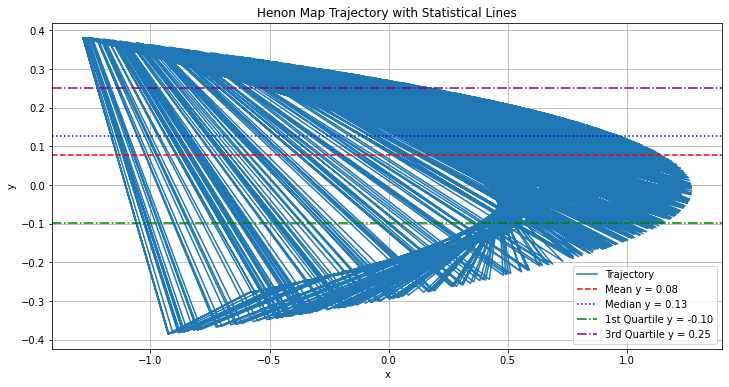

In [62]:
def find_intercepts_2d(x, y, line_y):
    """
    Identify where a 2D trajectory crosses a horizontal line y = line_y.

    Parameters:
    - x (array): x-coordinates of the trajectory.
    - y (array): y-coordinates of the trajectory.
    - line_y (float): The y-coordinate of the line to check for intercepts.

    Returns:
    - list: x-coordinates of points where the trajectory crosses the line.
    """
    intercepts = []
    for i in range(1, len(y)):
        if (y[i-1] < line_y and y[i] > line_y) or (y[i-1] > line_y and y[i] < line_y):
            # Linear interpolation to find the x-coordinate of the intercept
            slope = (x[i] - x[i-1]) / (y[i] - y[i-1])
            intercept_x = x[i-1] + (line_y - y[i-1]) / slope
            intercepts.append(intercept_x)
    return intercepts

def plot_trajectory_and_significant_lines(x, y, title='Trajectory with Significant Lines'):
    """
    Plot the trajectory of a 2D system with lines corresponding to significant statistical thresholds.
    
    Parameters:
    - x (list): x-coordinates of the trajectory.
    - y (list): y-coordinates of the trajectory.
    - title (str): Title of the plot.
    """
    mean_y = np.mean(y)
    std_y = np.std(y)
    median_y = np.median(y)
    quartile1 = np.percentile(y, 25)
    quartile3 = np.percentile(y, 75)

    plt.figure(figsize=(12, 6))
    plt.plot(x, y, label='Trajectory')
    plt.axhline(y=mean_y, color='red', linestyle='--', label=f'Mean y = {mean_y:.2f}')
    plt.axhline(y=median_y, color='blue', linestyle=':', label=f'Median y = {median_y:.2f}')
    plt.axhline(y=quartile1, color='green', linestyle='-.', label=f'1st Quartile y = {quartile1:.2f}')
    plt.axhline(y=quartile3, color='purple', linestyle='-.', label=f'3rd Quartile y = {quartile3:.2f}')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate data for the Henon map (as previously defined)
a, b = 1.4, 0.3
def henon_map(x, y):
    return y + 1 - a * x**2, b * x

x, y = 0, 0
xs, ys = [], []
for _ in range(1000):
    x, y = henon_map(x, y)
    xs.append(x)
    ys.append(y)

plot_trajectory_and_significant_lines(xs, ys, 'Henon Map Trajectory with Statistical Lines')


In [63]:
def lyapunov_exponent(x, y, num_iters, f_map):
    """ Calculate the first Lyapunov exponent for a 2D map """
    delta = 1e-5
    sum_log = 0.0
    for _ in range(num_iters):
        x_next, y_next = f_map(x, y)
        x_delta, y_delta = f_map(x + delta, y)
        delta_x = ((x_delta - x_next)**2 + (y_delta - y_next)**2)**0.5
        sum_log += np.log(delta_x / delta)
        x, y = x_next, y_next
    return sum_log / num_iters

# Calculate the Lyapunov exponent for the Henon map
L_exp = lyapunov_exponent(0, 0, 1000, henon_map)
print("Estimated Lyapunov Exponent:", L_exp)

Estimated Lyapunov Exponent: 0.49737152150168246


In [64]:
@nb.njit
def find_intercepts_2d(x, y, value):
    """
    Identify the intercepts where a 2D trajectory crosses a horizontal line at a specified value on the y-axis.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - value (float): The value on the y-axis to check for intercepts.
    
    Returns:
    - tuple of arrays: Arrays containing the x and y coordinates of the points where the trajectory crosses the specified value.
    """
    x_intercept = []
    y_intercept = []
    for i in range(len(y) - 1):
        if (y[i] < value and y[i + 1] > value) or (y[i] > value and y[i + 1] < value):
            # Linear interpolation to find the precise intercept point
            frac = (value - y[i]) / (y[i + 1] - y[i])
            x_intercept.append(x[i] + frac * (x[i + 1] - x[i]))
            y_intercept.append(value)
    return np.array(x_intercept), np.array(y_intercept)

@nb.njit
def smk(x, y, m, k):
    """
    Generate a subset of points from a 2D trajectory using a sliding window approach.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - m (int): The size of the sliding window.
    - k (int): The step size between successive windows.
    
    Returns:
    - ndarray: A 2D NumPy array containing points sampled according to the sliding window parameters.
    """
    N = len(x)
    num_points = (N - m) // k + 1
    s = np.zeros((num_points, 2))
    for i in range(num_points):
        index = i * k
        s[i, 0] = x[index]
        s[i, 1] = y[index]
    return s

@nb.njit
def lmk(x, y, m, k):
    """
    Calculate the approximate length of segments of a 2D trajectory using a sliding window.
    
    Parameters:
    - x (array of float): The x-coordinates.
    - y (array of float): The y-coordinates.
    - m (int): The size of the sliding window.
    - k (int): The step size between successive windows.
    
    Returns:
    - float: The scaled average distance covered in each segment of the trajectory.
    """
    points = smk(x, y, m, k)
    total_distance = 0.0
    for i in range(len(points) - 1):
        total_distance += np.linalg.norm(points[i + 1] - points[i])
    return total_distance / (len(points) - 1) if len(points) > 1 else 0

@nb.njit
def lk(x, y, k):
    """
    Compute the average length of a 2D trajectory using multiple sliding windows to enhance accuracy.
    
    Parameters:
    - x (array of float): The x-coordinates.
    - y (array of float): The y-coordinates.
    - k (int): The number of sliding windows to apply.
    
    Returns:
    - float: The average length computed over all specified window configurations.
    """
    total_length = 0.0
    for m in range(1, k + 1):
        total_length += lmk(x, y, m, k)
    return total_length / k

@nb.njit
def rk4_step_2d(x, y, dt, function):
    """
    Perform one step of the Runge-Kutta 4th order method for solving a 2D system of ODEs.

    Parameters:
    - x, y: Current x and y values.
    - dt: Time step.
    - function: The function that represents the dynamics of the system.

    Returns:
    - x_new, y_new: New x and y values after one RK4 step.
    """
    k1_x, k1_y = function(x, y)
    k2_x, k2_y = function(x + 0.5 * dt * k1_x, y + 0.5 * dt * k1_y)
    k3_x, k3_y = function(x + 0.5 * dt * k2_x, y + 0.5 * dt * k2_y)
    k4_x, k4_y = function(x + dt * k3_x, y + dt * k3_y)
    x_new = x + (dt / 6.0) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
    y_new = y + (dt / 6.0) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    return x_new, y_new

@nb.njit
def find_lk_for_k_2d(x, y, value, ks=np.arange(1, 20)):
    """
    Apply the Lk method to compute the trajectory length for various configurations of sliding window sizes, 
    evaluated at the intercepts with a specified horizontal line on the y-axis.

    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - value (float): The y-value to find intercepts.
    - ks (array of int, optional): The range of k-values (window sizes) to use.
    
    Returns:
    - tuple: Two arrays, the first containing the k-values used, and the second containing the logarithm of the Lk lengths.
    """
    x_intercept, y_intercept = find_intercepts_2d(x, y, value)
    l_de_k = np.zeros(len(ks), dtype=np.float64)
    for i in range(len(ks)):
        l_de_k[i] = lk(x_intercept, y_intercept, ks[i])
    return ks, np.log(l_de_k)


@nb.njit
def optimise_line_y(x, y, value_start=0.1, value_stop=1.0, step=0.1, max_diff=True):
    """
    Optimise the y-value to find the value that maximizes the average difference 
    in the logarithm of the trajectory lengths calculated by the Lk method.

    This function iterates through a range of y-values and determines the value
    at which the average difference of the logarithm of lengths of trajectories,
    intercepted at each y-value, is maximized or minimized.

    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - value_start (float, optional): The starting y-value of interest.
    - value_stop (float, optional): The ending y-value of interest.
    - step (float, optional): The increment step between y-values.
    - max_diff (bool, optional): Whether to maximize (True) or minimize (False) the difference.

    Returns:
    - float: The y-value that maximizes or minimizes the average difference of the logarithmic lengths.
    """
    possible_values = np.arange(value_start, value_stop, step)
    max_moy = -np.inf if max_diff else np.inf
    best_value = None

    for value in possible_values:
        ks, l_de_k = find_lk_for_k_2d(x, y, value)
        moyenne_dy = average_difference(l_de_k)
        if (max_diff and moyenne_dy > max_moy) or (not max_diff and moyenne_dy < max_moy):
            max_moy = moyenne_dy
            best_value = value

    return best_value


@nb.njit
def average_difference(points):
    """
    Calculate the average difference between consecutive values in a 1D list using Numba for performance optimization.

    Parameters:
    - points (array of float/int): Array of numeric values.

    Returns:
    - float: The average difference between each successive value.
    """
    n = len(points)
    if n < 2:
        return 0.0  # Return 0 if there are not enough points to compare

    total_difference = 0.0
    # Loop through the array of points and calculate the difference between consecutive points
    for i in range(1, n):
        difference = abs(points[i] - points[i-1])
        total_difference += difference

    # Calculate the average difference
    average_diff = total_difference / (n - 1)
    return average_diff

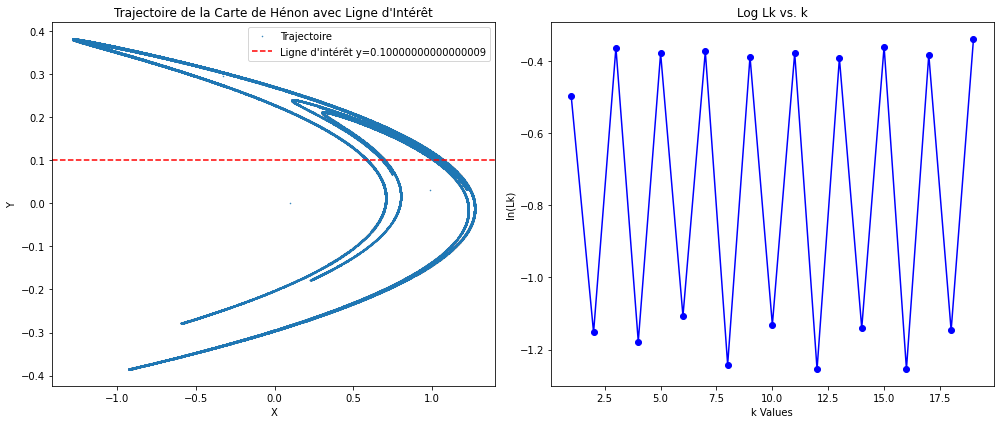

In [65]:
@nb.njit
def henon_map(x0=0.1, y0=0.0, a=1.4, b=0.3, num_steps=10000):
    """
    Generate the trajectory of the Hénon map.
    
    Parameters:
    - x0, y0 (float): Initial conditions for the Hénon map.
    - a, b (float): Parameters of the Hénon map.
    - num_steps (int): Number of iterations.
    
    Returns:
    - x, y (numpy.ndarray): Arrays of x and y coordinates of the Hénon map trajectory.
    """
    x, y = np.zeros(num_steps + 1), np.zeros(num_steps + 1)
    x[0], y[0] = x0, y0
    for i in range(num_steps):
        x[i + 1] = 1 - a * x[i] ** 2 + y[i]
        y[i + 1] = b * x[i]
    return x, y

# Générer la trajectoire de Hénon
x_henon, y_henon = henon_map(num_steps=100000)

# Trouver la meilleure ligne y
best_y = optimise_line_y(x_henon, y_henon, value_start=-1.5, value_stop=1.5, step=0.1)


# Calculer ln(Lk) pour la ligne d'intérêt spécifique
ks, ln_lk_values = find_lk_for_k_2d(x_henon, y_henon, best_y)

# Créer le graphique
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Premier graphique : Trajectoire et ligne d'intérêt
ax1.plot(x_henon, y_henon, '.', markersize=1, label='Trajectoire')
ax1.axhline(y=best_y, color='r', linestyle='--', label=f'Ligne d\'intérêt y={best_y}')
ax1.set_title('Trajectoire de la Carte de Hénon avec Ligne d\'Intérêt')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()

# Deuxième graphique : ln(Lk) en fonction de k
ax2.plot(ks, ln_lk_values, marker='o', linestyle='-', color='blue')
ax2.set_title('Log Lk vs. k')
ax2.set_xlabel('k Values')
ax2.set_ylabel('ln(Lk)')



plt.tight_layout()
plt.show()

In [66]:
@nb.njit
def brownian_motion(x0=0.0, y0=0.0, num_steps=10000, delta=0.1):
    """
    Generate the trajectory of a 2D Brownian motion.
    
    Parameters:
    - x0, y0 (float): Initial positions for the Brownian motion.
    - num_steps (int): Number of steps in the simulation.
    - delta (float): Scale of the Gaussian increments.
    
    Returns:
    - x, y (numpy.ndarray): Arrays of x and y coordinates of the Brownian motion trajectory.
    """
    x = np.empty(num_steps + 1)
    y = np.empty(num_steps + 1)
    x[0], y[0] = x0, y0
    for i in nb.prange(1, num_steps + 1):
        x[i] = x[i - 1] + np.random.normal() * delta
        y[i] = y[i - 1] + np.random.normal() * delta
    return x, y


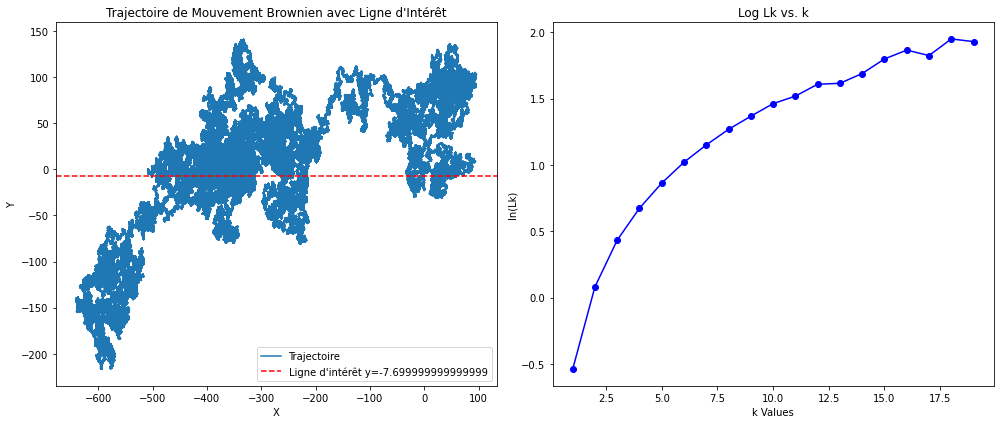

In [69]:
# Générer la trajectoire de mouvement brownien
x_brownian, y_brownian = brownian_motion(num_steps=10000000, delta=0.1)

# Trouver la meilleure ligne y pour le mouvement brownien
best_y_brownian = optimise_line_y(x_brownian, y_brownian, value_start=-15, value_stop=15, step=0.1)

# Calculer ln(Lk) pour la ligne d'intérêt spécifique
ks_brownian, ln_lk_values_brownian = find_lk_for_k_2d(x_brownian, y_brownian, best_y_brownian)

# Créer le graphique
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Premier graphique : Trajectoire et ligne d'intérêt
ax1.plot(x_brownian, y_brownian, markersize=1, label='Trajectoire')
ax1.axhline(y=best_y_brownian, color='r', linestyle='--', label=f'Ligne d\'intérêt y={best_y_brownian}')
ax1.set_title('Trajectoire de Mouvement Brownien avec Ligne d\'Intérêt')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()

# Deuxième graphique : ln(Lk) en fonction de k
ax2.plot(ks_brownian, ln_lk_values_brownian, marker='o', linestyle='-', color='blue')
ax2.set_title('Log Lk vs. k')
ax2.set_xlabel('k Values')
ax2.set_ylabel('ln(Lk)')


plt.tight_layout()
plt.show()
